In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import functionsML as f
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [21]:
# Função de Limpeza Básica (Sem Leakage)
def clean_data(df):
    df = df.copy()
    
    # Drop irrelevant
    df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
    for col in df.select_dtypes(include="object").columns:
        df = f.fix_typos(col, df)

    # Transmission: 'other' passa a 'unknown'
    df['transmission'] = df['transmission'].replace('other', 'unknown')
    
    # FuelType: 'other' passa a 'electric' (conforme o teu código antigo)
    df['fuelType'] = df['fuelType'].replace('other', 'electric')

    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan # Opcional conforme o teu código

    # Numeric Transformations
    df['mileage'] = np.log1p(df['mileage'])
    df['mpg'] = np.log1p(df['mpg'])
    df['tax'] = np.log1p(df['tax'])
    
    # Types and Rounding
    df["year"] = df["year"].round()
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")

    df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")
    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df

In [22]:
def clean_data(df):
    df = df.copy()
    
    # Drop irrelevant
    df = df.drop(columns=["hasDamage","paintQuality%"], errors='ignore')
    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
    for col in df.select_dtypes(include="object").columns:
        df = f.fix_typos(col, df)

    # Transmission: 'other' passa a 'unknown'
    df['transmission'] = df['transmission'].replace('other', 'unknown')
    
    # FuelType: 'other' passa a 'electric' (conforme o teu cÃ³digo antigo)
    df['fuelType'] = df['fuelType'].replace('other', 'electric')

    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    df.loc[~df["previousOwners"].between(0, 6), "previousOwners"] = np.nan
    mask = (df['year'] % 1 != 0)
    df.loc[mask, 'year'] = np.nan
    mask = (df['mileage'] % 1 != 0)
    df.loc[mask, 'mileage'] = np.nan
    mask = (df['tax'] % 1 != 0)
    df.loc[mask, 'tax'] = np.nan
    mask = df['mpg'] != df['mpg'].round(1)
    df.loc[mask, 'mpg'] = np.nan
    mask = df['engineSize'] != df['engineSize'].round(1)
    df.loc[mask, 'engineSize'] = np.nan

    # Numeric Transformations
    df['mileage'] = np.log1p(df['mileage'])
    df['mpg'] = np.log1p(df['mpg'])
    df['tax'] = np.log1p(df['tax'])
    
    # Types and Rounding
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors='coerce').round().astype("Int64")
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")

    df["previousOwners"] = df["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64")
    
    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor  # <--- MUDANÇA AQUI
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint
import functionsML as f # Assumindo que tens as tuas funções aqui

# --- 1. CONFIGURAÇÃO E CARREGAMENTO ---

train_db = pd.read_csv("./train.csv")
train_db['price_log'] = np.log1p(train_db['price'])

# Split Treino / Validação
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# Limpeza
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# --- 2. SEPARAÇÃO LUXURY VS OTHERS ---
luxury_brands = ['mercedes', 'audi', 'bmw']
mask_train = train_set['Brand'].str.lower().isin(luxury_brands)
mask_val = val_set['Brand'].str.lower().isin(luxury_brands)

# Datasets separados
train_lux = train_set[mask_train].copy()
train_oth = train_set[~mask_train].copy()
val_lux = val_set[mask_val].copy()
val_oth = val_set[~mask_val].copy()

# --- 3. FUNÇÃO DE TREINO (ADAPTADA PARA EXTRA TREES) ---
def train_and_evaluate_et(train_df, val_df, group_name):
    # A. Target Encoding
    mapping = train_df.groupby(["Brand", "model"])["price_log"].mean().to_dict()
    global_mean = train_df["price_log"].mean()
    
    # B. Encoding & Prep
    train_len = len(train_df)
    combined = pd.concat([train_df, val_df], axis=0)
    
    # Target Encode
    combined["Brand_model_encoded"] = combined.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
    
    # One-Hot Encode
    combined = pd.get_dummies(combined, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    # Separar X e y
    drop_cols = ["price", "price_log", "carID", "model", "previousOwners"]
    X_train = combined.iloc[:train_len].drop(columns=drop_cols, errors='ignore')
    y_train = combined.iloc[:train_len]["price_log"]
    X_val = combined.iloc[train_len:].drop(columns=drop_cols, errors='ignore')
    y_val = combined.iloc[train_len:]["price_log"]
    
    # Scaling
    train_cols = X_train.columns
    scaler = MinMaxScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=train_cols)
    X_val_s = pd.DataFrame(scaler.transform(X_val), columns=train_cols)
    
    # C. Setup para RandomizedSearch
    X_comb = pd.concat([X_train_s, X_val_s], axis=0).reset_index(drop=True)
    y_comb = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    
    # Predefined Split (-1 = Treino, 0 = Validação)
    ps = PredefinedSplit([-1]*len(X_train_s) + [0]*len(X_val_s))
    
    # --- MUDANÇA PRINCIPAL: EXTRA TREES ---
    # bootstrap=False é comum em ExtraTrees (usa o dataset todo), mas podes testar True.
    et_model = ExtraTreesRegressor(random_state=42, n_jobs=-1, bootstrap=False)
    
    # Grelha de Hiperparâmetros para Extra Trees
    param_dist = {
        'n_estimators': [500],
        'max_features': [1.0],
        'max_depth': [30],
        'min_samples_leaf': [1],
        'min_samples_split': [10]
    }
    
    search = RandomizedSearchCV(
        estimator=et_model, 
        param_distributions=param_dist, 
        n_iter=50,  # ExtraTrees é rápido, 20 iterações é tranquilo
        cv=ps, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1, 
        random_state=42,
        verbose=1
    )
    
    print(f"\n>>> Treinando ExtraTrees - Grupo: {group_name}")
    search.fit(X_comb, y_comb)
    best_et = search.best_estimator_
    print(f"Melhores Params ({group_name}): {search.best_params_}")
    
    # D. Análise de Overfit
    p_train = best_et.predict(X_train_s)
    p_val = best_et.predict(X_val_s)
    
    # Métricas
    r2_train = r2_score(y_train, p_train)
    r2_val = r2_score(y_val, p_val)
    
    # Converter Log -> Reais para RMSE
    rmse_train = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(p_train)))
    rmse_val = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(p_val)))
    
    print(f"[{group_name}] R² Treino: {r2_train:.4f} | R² Validação: {r2_val:.4f}")
    print(f"[{group_name}] RMSE Treino: {rmse_train:.2f}€ | RMSE Validação: {rmse_val:.2f}€")
    
    gap = (rmse_val - rmse_train) / rmse_train * 100
    print(f"[{group_name}] Gap de Overfit: {gap:.2f}%")
    
    return best_et, scaler, mapping, global_mean, train_cols

# --- 4. EXECUÇÃO DOS GRUPOS ---
print("--- INICIANDO MODELAGEM LUXURY ---")
model_lux_et, sc_lux, map_lux, mean_lux, cols_lux = train_and_evaluate_et(train_lux, val_lux, "LUXURY")

print("\n--- INICIANDO MODELAGEM OTHERS ---")
model_oth_et, sc_oth, map_oth, mean_oth, cols_oth = train_and_evaluate_et(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db) # Usa a tua função de limpeza

def predict_group(df, model, scaler, mapping, g_mean, train_cols):
    if df.empty: return pd.DataFrame()
    
    df_enc = df.copy()
    # Target Encode com mapping do treino
    df_enc["Brand_model_encoded"] = df_enc.apply(lambda x: mapping.get((x["Brand"], x["model"]), g_mean), axis=1)
    
    # One Hot
    df_enc = pd.get_dummies(df_enc, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    # Alinhamento
    X_test = df_enc.reindex(columns=train_cols, fill_value=0)
    
    # Scaling
    X_test_s = scaler.transform(X_test)
    
    # Prever e inverter log
    preds = np.expm1(model.predict(X_test_s))
    
    return pd.DataFrame({"carID": df["carID"], "price": preds})

# Separar teste
mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)

# Prever separadamente
sub_lux = predict_group(test_clean[mask_test], model_lux_et, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = predict_group(test_clean[~mask_test], model_oth_et, sc_oth, map_oth, mean_oth, cols_oth)

# Juntar e Salvar
submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_extratrees_split.csv", index=False)
print("\nSubmissão 'submission_extratrees_split.csv' salva com sucesso!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

--- INICIANDO MODELAGEM LUXURY ---

>>> Treinando ExtraTrees - Grupo: LUXURY
Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Params (LUXURY): {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30}
[LUXURY] R² Treino: 0.9783 | R² Validação: 0.9790
[LUXURY] RMSE Treino: 1921.80€ | RMSE Validação: 1706.01€
[LUXURY] Gap de Overfit: -11.23%

--- INICIANDO MODELAGEM OTHERS ---

>>> Treinando ExtraTrees - Grupo: OTHERS
Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Params (OTHERS): {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 30}
[OTHERS] R² Treino: 0.9784 | R² Validação: 0.9783
[OTHERS] RMSE Treino: 1012.77€ | RMSE Validação: 917.20€
[OTHERS] Gap de Overfit: -9.44%


c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group


Submissão 'submission_extratrees_split.csv' salva com sucesso!


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import HistGradientBoostingRegressor # <--- O NOSSO MODELO
from sklearn.metrics import mean_squared_error, r2_score
import functionsML as f 


train_db = pd.read_csv("./train.csv")
train_db['price_log'] = np.log1p(train_db['price'])

# Split Treino / Validação
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# Limpeza
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# --- 2. SEPARAÇÃO LUXURY VS OTHERS ---
luxury_brands = ['mercedes', 'audi', 'bmw']
mask_train = train_set['Brand'].str.lower().isin(luxury_brands)
mask_val = val_set['Brand'].str.lower().isin(luxury_brands)

# Datasets separados
train_lux = train_set[mask_train].copy()
train_oth = train_set[~mask_train].copy()
val_lux = val_set[mask_val].copy()
val_oth = val_set[~mask_val].copy()

# --- 3. FUNÇÃO DE TREINO (ADAPTADA PARA HIST GRADIENT BOOSTING) ---
def train_and_evaluate_hgb(train_df, val_df, group_name):
    # A. Target Encoding
    mapping = train_df.groupby(["Brand", "model"])["price_log"].mean().to_dict()
    global_mean = train_df["price_log"].mean()
    
    # B. Encoding & Prep
    train_len = len(train_df)
    combined = pd.concat([train_df, val_df], axis=0)
    
    # Target Encode
    combined["Brand_model_encoded"] = combined.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
    
    # One-Hot Encode
    combined = pd.get_dummies(combined, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    # Separar X e y
    drop_cols = ["price", "price_log", "carID", "model", "previousOwners"]
    X_train = combined.iloc[:train_len].drop(columns=drop_cols, errors='ignore')
    y_train = combined.iloc[:train_len]["price_log"]
    X_val = combined.iloc[train_len:].drop(columns=drop_cols, errors='ignore')
    y_val = combined.iloc[train_len:]["price_log"]
    
    # Scaling (O HistGB não obriga, mas ajuda a manter consistência com o resto do projeto)
    train_cols = X_train.columns
    scaler = MinMaxScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=train_cols)
    X_val_s = pd.DataFrame(scaler.transform(X_val), columns=train_cols)
    
    # C. Setup para RandomizedSearch
    X_comb = pd.concat([X_train_s, X_val_s], axis=0).reset_index(drop=True)
    y_comb = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    
    # Predefined Split (-1 = Treino, 0 = Validação)
    ps = PredefinedSplit([-1]*len(X_train_s) + [0]*len(X_val_s))
    
    # --- MODELO HIST GRADIENT BOOSTING ---
    hgb_model = HistGradientBoostingRegressor(
        loss='squared_error',
        random_state=42,
        early_stopping=False # Desligamos o interno porque usamos CV fixo
    )
    
    # Grelha de Hiperparâmetros (Os teus melhores parâmetros)
    param_dist = {
        'l2_regularization': [0.5], 
    
        # 2. Controlar a Complexidade
        # 118 folhas é muito. Vamos testar valores mais baixos.
        'max_leaf_nodes': [80], 
        'max_depth': [10], # Limitar a profundidade também
    
        # 3. Features e Learning Rate
        'learning_rate': [0.05],
        'max_iter': [3000],
    
        # IMPORTANTE: Tentar simular o 'log2' do GB
        # Baixar isto obriga cada árvore a ser mais independente
        'max_features': [0.3] 

    }
    
    search = RandomizedSearchCV(
        estimator=hgb_model, 
        param_distributions=param_dist, 
        n_iter=50, 
        cv=ps, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1, 
        random_state=42,
        verbose=1
    )
    
    print(f"\n>>> Treinando HistGB - Grupo: {group_name}")
    search.fit(X_comb, y_comb)
    best_hbg = search.best_estimator_
    print(f"Melhores Params ({group_name}): {search.best_params_}")
    
    # D. Análise de Overfit
    p_train = best_hbg.predict(X_train_s)
    p_val = best_hbg.predict(X_val_s)
    
    # Métricas
    r2_train = r2_score(y_train, p_train)
    r2_val = r2_score(y_val, p_val)
    
    # Converter Log -> Reais para RMSE
    rmse_train = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(p_train)))
    rmse_val = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(p_val)))
    
    print(f"[{group_name}] R² Treino: {r2_train:.4f} | R² Validação: {r2_val:.4f}")
    print(f"[{group_name}] RMSE Treino: {rmse_train:.2f}€ | RMSE Validação: {rmse_val:.2f}€")
    
    gap = (rmse_val - rmse_train) / rmse_train * 100
    print(f"[{group_name}] Gap de Overfit: {gap:.2f}%")
    
    return best_hbg, scaler, mapping, global_mean, train_cols

# --- 4. EXECUÇÃO DOS GRUPOS ---
print("--- INICIANDO MODELAGEM LUXURY (HistGB) ---")
model_lux_hgb, sc_lux, map_lux, mean_lux, cols_lux = train_and_evaluate_hgb(train_lux, val_lux, "LUXURY")

print("\n--- INICIANDO MODELAGEM OTHERS (HistGB) ---")
model_oth_hgb, sc_oth, map_oth, mean_oth, cols_oth = train_and_evaluate_hgb(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db) 

def predict_group(df, model, scaler, mapping, g_mean, train_cols):
    if df.empty: return pd.DataFrame()
    
    df_enc = df.copy()
    # Target Encode
    df_enc["Brand_model_encoded"] = df_enc.apply(lambda x: mapping.get((x["Brand"], x["model"]), g_mean), axis=1)
    
    # One Hot
    df_enc = pd.get_dummies(df_enc, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    # Alinhamento
    X_test = df_enc.reindex(columns=train_cols, fill_value=0)
    
    # Scaling
    X_test_s = scaler.transform(X_test)
    
    # Prever e inverter log
    preds = np.expm1(model.predict(X_test_s))
    
    return pd.DataFrame({"carID": df["carID"], "price": preds})

# Separar teste
mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)

# Prever separadamente
sub_lux = predict_group(test_clean[mask_test], model_lux_hgb, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = predict_group(test_clean[~mask_test], model_oth_hgb, sc_oth, map_oth, mean_oth, cols_oth)

# Juntar e Salvar
submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_histgb_split.csv", index=False)
print("\nSubmissão 'submission_histgb_split.csv' salva com sucesso!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

--- INICIANDO MODELAGEM LUXURY (HistGB) ---

>>> Treinando HistGB - Grupo: LUXURY
Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Params (LUXURY): {'max_leaf_nodes': 80, 'max_iter': 3000, 'max_features': 0.3, 'max_depth': 10, 'learning_rate': 0.05, 'l2_regularization': 0.5}
[LUXURY] R² Treino: 0.9793 | R² Validação: 0.9800
[LUXURY] RMSE Treino: 1787.06€ | RMSE Validação: 1677.48€
[LUXURY] Gap de Overfit: -6.13%

--- INICIANDO MODELAGEM OTHERS (HistGB) ---

>>> Treinando HistGB - Grupo: OTHERS
Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Melhores Params (OTHERS): {'max_leaf_nodes': 80, 'max_iter': 3000, 'max_features': 0.3, 'max_depth': 10, 'learning_rate': 0.05, 'l2_regularization': 0.5}
[OTHERS] R² Treino: 0.9760 | R² Validação: 0.9758
[OTHERS] RMSE Treino: 1054.59€ | RMSE Validação: 972.24€
[OTHERS] Gap de Overfit: -7.81%


c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group


Submissão 'submission_histgb_split.csv' salva com sucesso!


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint



# --- 2. CARREGAMENTO E SPLIT ---
train_db = pd.read_csv("./train.csv")
train_db['price_log'] = np.log1p(train_db['price'])

train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

train_set = clean_data(train_set)
val_set = clean_data(val_set)

luxury_brands = ['mercedes', 'audi', 'bmw']
mask_train = train_set['Brand'].str.lower().isin(luxury_brands)
mask_val = val_set['Brand'].str.lower().isin(luxury_brands)

train_lux = train_set[mask_train].copy()
train_oth = train_set[~mask_train].copy()
val_lux = val_set[mask_val].copy()
val_oth = val_set[~mask_val].copy()

# --- 3. FUNÇÃO PRINCIPAL COM TESTE DE OVERFIT ---
def train_and_evaluate(train_df, val_df, group_name):
    # A. Target Encoding
    mapping = train_df.groupby(["Brand", "model"])["price_log"].mean().to_dict()
    global_mean = train_df["price_log"].mean()
    
    # B. Encoding & Prep
    train_len = len(train_df)
    combined = pd.concat([train_df, val_df], axis=0)
    combined["Brand_model_encoded"] = combined.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
    combined = pd.get_dummies(combined, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    drop_cols = ["price", "price_log", "carID", "model", "previousOwners"]
    X_train = combined.iloc[:train_len].drop(columns=drop_cols, errors='ignore')
    y_train = combined.iloc[:train_len]["price_log"]
    X_val = combined.iloc[train_len:].drop(columns=drop_cols, errors='ignore')
    y_val = combined.iloc[train_len:]["price_log"]
    
    train_cols = X_train.columns
    scaler = MinMaxScaler()
    X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=train_cols)
    X_val_s = pd.DataFrame(scaler.transform(X_val), columns=train_cols)
    
    # C. Randomized Search
    X_comb = pd.concat([X_train_s, X_val_s], axis=0).reset_index(drop=True)
    y_comb = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    ps = PredefinedSplit([-1]*len(X_train_s) + [0]*len(X_val_s))
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    param_dist = {
        'n_estimators': [500,1000],
        'max_depth': [10,15, 20, 30, None],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 4)
    }
    
    search = RandomizedSearchCV(
        estimator=rf, param_distributions=param_dist, n_iter=50, 
        cv=ps, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42
    )
    
    print(f"\n>>> Treinando Grupo: {group_name}")
    search.fit(X_comb, y_comb)
    best_model = search.best_estimator_
    
    # D. MÁGICA DO OVERFIT: Comparar Train vs Val
    p_train = best_model.predict(X_train_s)
    p_val = best_model.predict(X_val_s)
    
    # Métricas no Log (para R2) e Original (para RMSE em Euros)
    r2_train = r2_score(y_train, p_train)
    r2_val = r2_score(y_val, p_val)
    
    rmse_train = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(p_train)))
    rmse_val = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(p_val)))
    
    print(f"[{group_name}] R² Treino: {r2_train:.4f} | R² Validação: {r2_val:.4f}")
    print(f"[{group_name}] RMSE Treino: {rmse_train:.2f}€ | RMSE Validação: {rmse_val:.2f}€")
    
    gap = (rmse_val - rmse_train) / rmse_train * 100
    print(f"[{group_name}] Gap de Overfit: {gap:.2f}%")
    
    return best_model, scaler, mapping, global_mean, train_cols

# --- 4. EXECUÇÃO ---
model_lux_rf, sc_lux, map_lux, mean_lux, cols_lux = train_and_evaluate(train_lux, val_lux, "LUXURY")
model_oth_rf, sc_oth, map_oth, mean_oth, cols_oth = train_and_evaluate(train_oth, val_oth, "OTHERS")

# --- 5. PREDIÇÃO TESTE FINAL ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)

def predict_group(df, model, scaler, mapping, g_mean, train_cols):
    if df.empty: return pd.DataFrame()
    df_enc = df.copy()
    df_enc["Brand_model_encoded"] = df_enc.apply(lambda x: mapping.get((x["Brand"], x["model"]), g_mean), axis=1)
    df_enc = pd.get_dummies(df_enc, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    X_test = df_enc.reindex(columns=train_cols, fill_value=0)
    X_test_s = scaler.transform(X_test)
    preds = np.expm1(model.predict(X_test_s))
    return pd.DataFrame({"carID": df["carID"], "price": preds})

mask_test = test_clean['Brand'].str.lower().isin(luxury_brands)
sub_lux = predict_group(test_clean[mask_test], model_lux_rf, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = predict_group(test_clean[~mask_test], model_oth_rf, sc_oth, map_oth, mean_oth, cols_oth)

submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_overfit_checked.csv", index=False)
print("\nSubmissão salva com sucesso!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group


>>> Treinando Grupo: LUXURY
[LUXURY] R² Treino: 0.9846 | R² Validação: 0.9846
[LUXURY] RMSE Treino: 1772.40€ | RMSE Validação: 1543.96€
[LUXURY] Gap de Overfit: -12.89%

>>> Treinando Grupo: OTHERS
[OTHERS] R² Treino: 0.9788 | R² Validação: 0.9787
[OTHERS] RMSE Treino: 983.12€ | RMSE Validação: 908.91€
[OTHERS] Gap de Overfit: -7.55%


c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group


Submissão salva com sucesso!


In [32]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

# --- 1. RECOLHER OS MODELOS JÁ TREINADOS ---
# Tens de garantir que estas variáveis existem. 
# Se sobrescreveste 'model_lux' nas células anteriores, tens de voltar atrás e correr os treinos 
# (ou atribuir nomes diferentes) para teres os 3 disponíveis simultaneamente.

# Exemplo de como devem estar organizados (substitui pelas tuas variáveis reais):
models_luxury = {
    'RF': model_lux_rf,   # O teu melhor Random Forest (Luxury)
    'ET': model_lux_et,   # O teu melhor Extra Trees (Luxury)
    'HGB': model_lux_hgb  # O teu melhor HistGradientBoosting (Luxury)
}

models_others = {
    'RF': model_oth_rf,   # O teu melhor Random Forest (Others)
    'ET': model_oth_et,   # O teu melhor Extra Trees (Others)
    'HGB': model_oth_hgb  # O teu melhor HistGradientBoosting (Others)
}

# --- 2. PREPARAR DADOS (Recuperar X e y para cada grupo) ---
# Precisamos disto para o 'fit' do VotingRegressor conseguir calcular os erros e ajustar pesos

# (Assume-se que train_lux, val_lux, train_oth, val_oth já existem da célula anterior)

def prepare_data_for_ensemble(train_df, val_df):
    # Target Encoding (Usar lógica rápida)
    mapping = train_df.groupby(["Brand", "model"])["price_log"].mean().to_dict()
    global_mean = train_df["price_log"].mean()
    
    combined = pd.concat([train_df, val_df], axis=0)
    combined["Brand_model_encoded"] = combined.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
    combined = pd.get_dummies(combined, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    
    drop_cols = ["price", "price_log", "carID", "model", "previousOwners"]
    train_len = len(train_df)
    
    X = combined.drop(columns=drop_cols, errors='ignore')
    y = combined["price_log"]
    
    # Scaling (Obrigatório para consistência)
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Separar para criar o PredefinedSplit corretamente
    X_train_s = X_scaled.iloc[:train_len]
    X_val_s = X_scaled.iloc[train_len:]
    y_train = y.iloc[:train_len]
    y_val = y.iloc[train_len:]
    
    # Juntar tudo para o RandomizedSearch
    X_final = pd.concat([X_train_s, X_val_s], axis=0).reset_index(drop=True)
    y_final = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    
    # Criar PS
    split_index = ([-1] * len(X_train_s)) + ([0] * len(X_val_s))
    ps = PredefinedSplit(test_fold=split_index)
    
    return X_final, y_final, ps, scaler, mapping, global_mean, X_train_s.columns

# Preparar dados Luxo
print(">>> A preparar dados LUXURY...")
X_lux_comb, y_lux_comb, ps_lux, sc_lux, map_lux, mean_lux, cols_lux = prepare_data_for_ensemble(train_lux, val_lux)

# Preparar dados Outros
print(">>> A preparar dados OTHERS...")
X_oth_comb, y_oth_comb, ps_oth, sc_oth, map_oth, mean_oth, cols_oth = prepare_data_for_ensemble(train_oth, val_oth)


# --- 3. FUNÇÃO DE OTIMIZAÇÃO DE PESOS (A MÁGICA) ---
def optimize_ensemble_weights(models_dict, X, y, ps, group_name):
    estimators_list = list(models_dict.items())
    model_names = [name for name, _ in estimators_list]
    n_models = len(estimators_list)
    
    # Gerar combinações de pesos
    random.seed(42)
    weights_combinations = []
    for _ in range(100): # 100 tentativas
        w = []
        for _ in range(n_models):
            if random.random() < 0.2: w.append(0) # 20% chance de dropar modelo
            else: w.append(random.randint(1, 100))
        if sum(w) == 0: w[0] = 50
        weights_combinations.append(w)
    weights_combinations.append([1] * n_models) # Média simples
    
    # Configurar Voting
    voting_base = VotingRegressor(estimators=estimators_list, n_jobs=-1)
    
    param_grid = {'weights': weights_combinations}
    
    search = RandomizedSearchCV(
        estimator=voting_base,
        param_distributions=param_grid,
        n_iter=50,
        cv=ps,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    print(f"\n🧠 Otimizando Pesos para {group_name}...")
    search.fit(X, y)
    
    # Relatório
    best_weights = search.best_params_['weights']
    print(f"🏆 Melhor RMSE ({group_name}): {-search.best_score_:.5f}")
    print(f"⚖️ Pesos Ideais: {list(zip(model_names, best_weights))}")
    
    return search.best_estimator_

# --- 4. EXECUTAR OTIMIZAÇÃO ---
print("\n=== ENSEMBLE LUXURY ===")
ensemble_lux = optimize_ensemble_weights(models_luxury, X_lux_comb, y_lux_comb, ps_lux, "LUXURY")

print("\n=== ENSEMBLE OTHERS ===")
ensemble_oth = optimize_ensemble_weights(models_others, X_oth_comb, y_oth_comb, ps_oth, "OTHERS")


# --- 5. SUBMISSÃO FINAL (ENSEMBLE SPLIT) ---
test_db = pd.read_csv("./test.csv")
test_clean = clean_data(test_db)

def predict_ensemble(df, model, scaler, mapping, g_mean, train_cols):
    if df.empty: return pd.DataFrame()
    df_enc = df.copy()
    df_enc["Brand_model_encoded"] = df_enc.apply(lambda x: mapping.get((x["Brand"], x["model"]), g_mean), axis=1)
    df_enc = pd.get_dummies(df_enc, columns=["Brand", "transmission", "fuelType"], drop_first=True)
    X_test = df_enc.reindex(columns=train_cols, fill_value=0)
    X_test_s = scaler.transform(X_test)
    preds = np.expm1(model.predict(X_test_s))
    return pd.DataFrame({"carID": df["carID"], "price": preds})

mask_test = test_clean['Brand'].str.lower().isin(['mercedes', 'audi', 'bmw'])

sub_lux = predict_ensemble(test_clean[mask_test], ensemble_lux, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = predict_ensemble(test_clean[~mask_test], ensemble_oth, sc_oth, map_oth, mean_oth, cols_oth)

submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_ensemble_split_optimized.csv", index=False)
print("\n✅ Submissão 'submission_ensemble_split_optimized.csv' criada com sucesso!")

>>> A preparar dados LUXURY...
>>> A preparar dados OTHERS...

=== ENSEMBLE LUXURY ===

🧠 Otimizando Pesos para LUXURY...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
🏆 Melhor RMSE (LUXURY): 0.10901
⚖️ Pesos Ideais: [('RF', 11), ('ET', 13), ('HGB', 59)]

=== ENSEMBLE OTHERS ===

🧠 Otimizando Pesos para OTHERS...
Fitting 1 folds for each of 50 candidates, totalling 50 fits
🏆 Melhor RMSE (OTHERS): 0.10124
⚖️ Pesos Ideais: [('RF', 21), ('ET', 61), ('HGB', 97)]


c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group


✅ Submissão 'submission_ensemble_split_optimized.csv' criada com sucesso!


# Linear Regression

In [79]:
# 1. Load Data
train_db = pd.read_csv("./train.csv")
# Important: Apply log to the target right at the start (if that is the strategy)
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Initial Split)
# Here we ensure that validation data never sees the training data
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Independent Cleaning (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Where Data Leakage occurs if not careful)

# A. One-Hot Encoding
# We must ensure columns match. We concatenate just to generate dummies, then separate again.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Split back to Train and Validation
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT on Train, TRANSFORM on Train and Validation)
# Calculate means on Train
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Apply to Train
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Apply to Validation (using the training mapping!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. FINAL PREPARATION (X and y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Columns to remove

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT on Train, TRANSFORM on both)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

In [80]:
# 1. Combine processed data (Reset index to ensure alignment)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Create the Split "Mask" (test_fold)
# -1 indicates: "This sample is for training, use it to learn"
#  0 indicates: "This sample is for validation, use it to test" (0 is the index of the validation fold)

# Array with -1 for the length of the training set
split_index_train = [-1] * len(X_train_scaled)
# Array with 0 for the length of the validation set
split_index_val = [0] * len(X_val_scaled)

# Combine the two lists
test_fold = split_index_train + split_index_val

# 3. Create the PredefinedSplit Object
ps = PredefinedSplit(test_fold)

experimentar com fit.x_combined,y_combnd

In [ ]:
# 1. Filtrar os dados manualmente (já que não vamos usar o RandomizedSearch)
# O ps.test_fold tem -1 (Treino) e 0 (Validação)
X_train_lr = X_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == -1]]
y_train_lr = y_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == -1]]

X_val_lr = X_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == 0]]
y_val_lr = y_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == 0]]

# 2. Treinar
lr_model = LinearRegression(n_jobs=-1)
print("A treinar Regressão Linear Simples...")
lr_model.fit(X_train_lr, y_train_lr)

# 3. Validar
y_pred_log = lr_model.predict(X_val_lr)
rmse_log = np.sqrt(mean_squared_error(y_val_lr, y_pred_log))

print(f"RMSE Linear Simples (log): {rmse_log:.4f}")

# Definir como o "best_model" para usares nos gráficos abaixo
best_lr = lr_model

A treinar Regressão Linear Simples...
RMSE Linear Simples (log): 0.1740


In [82]:
# --- GENERATE SUBMISSION FOR LINEAR REGRESSION ---

# 1. Load Test Data
test_db = pd.read_csv("./test.csv")

# 2. Clean Data (Apply the exact same cleaning function used in training)
test_clean = clean_data(test_db) 

# 3. ENCODING

# A. One-Hot Encoding
# We generate dummies first. Columns might differ from training, but we fix this in step 5.
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# CRITICAL: Use the 'mapping' and 'global_mean' calculated on the TRAIN set.
if 'mapping' in locals() and 'global_mean' in locals():
    test_encoded["Brand_model_encoded"] = test_clean.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
else:
    raise ValueError("Error: 'mapping' or 'global_mean' from training not found.")

# 4. FINAL PREPARATION
# Remove the same columns dropped during training
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_lr = test_encoded.drop(columns=drop_cols, errors='ignore')

# 5. COLUMN ALIGNMENT (Crucial for Linear Regression)
# Linear Regression fails instantly if column order or number is different.
# We force the test set to match X_combined (training structure) exactly.
if 'X_combined' in locals():
    train_cols = X_combined.columns
    X_test_lr = X_test_lr.reindex(columns=train_cols, fill_value=0)
else:
    raise ValueError("Error: X_combined (training data) not found for alignment.")

# 6. SCALING
# Use the scaler fitted on training data
X_test_lr_scaled = pd.DataFrame(scaler.transform(X_test_lr), columns=X_test_lr.columns, index=X_test_lr.index)

# 7. PREDICTION
# Use 'best_lr' 
print("Making predictions with Linear Regression model...")
y_pred_lr_log = best_lr.predict(X_test_lr_scaled)

# 8. INVERT LOG (Convert back to Euros)
y_pred_lr_real = np.expm1(y_pred_lr_log)

# 9. SAVE SUBMISSION
submission_lr = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_lr_real
})

submission_lr.to_csv("submission_lr.csv", index=False)
print("Success! File 'submission_lr.csv' created.")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

Making predictions with Linear Regression model...
Success! File 'submission_lr.csv' created.


# KNN (K-Nearest Neighbors)

### Hyperparameter Tuning (K-Nearest Neighbors)

We implement K-Nearest Neighbors (KNN), an instance-based learning algorithm that predicts the price of a car based on the average price of the 'k' most similar cars in the dataset.

`Prerequisite (Scaling)`: KNN is distance-based, meaning it is highly sensitive to the scale of data. It is critical that we use X_combined (which uses MinMaxScaling), otherwise, features with large numbers (like mileage) would dominate features with small numbers (like year).

`n_neighbors (k)`: We test values from 3 to 50. Low 'k' captures local details (but risks overfitting to noise), while high 'k' smooths the prediction (but risks underfitting).

`weights`: We test 'distance' vs 'uniform'. In car pricing, 'distance' is usually superior because a car that is almost identical to the target should have more influence on the price than a car that is merely "somewhat similar".

`metric`: We explore Manhattan (L1) and Euclidean (L2) distances. Manhattan distance often performs better in high-dimensional spaces created by One-Hot Encoding (sparse data)./6

In [ ]:
# 1. Definir o Modelo Base
knn_model = KNeighborsRegressor(n_jobs=-1)

# 2. Definir a Grelha de Hiperparâmetros
param_dist_knn = {
    # n_neighbors: 'K'. Valores baixos (3) ajustam muito, altos (50) generalizam.
    'n_neighbors': randint(3, 50),
    
    # weights: 
    # 'uniform' = todos os vizinhos valem o mesmo.
    # 'distance' = vizinhos mais próximos têm mais peso (geralmente melhor para preços)
    'weights': ['uniform', 'distance'],
    
    # metric: Como medir a distância entre os carros
    # 'manhattan' (L1) costuma funcionar bem com muitas colunas (high-dim)
    # 'euclidean' (L2) é o padrão geométrico
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    
    # p: Só é usado se metric='minkowski' (1=Manhattan, 2=Euclidean)
    'p': [1, 2]
}

# 3. Configurar RandomizedSearchCV (Usando o MESMO 'ps' e 'X_combined')
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=50,     # KNN é muito rápido, podemos testar 30 combinações
    cv=ps,         # Reutilizamos o PredefinedSplit criado no passo anterior
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para KNN com Predefined Split...")
# IMPORTANTE: X_combined já está escalado (MinMaxScaler), o que é obrigatório para KNN!
random_search_knn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros KNN: {random_search_knn.best_params_}")
print(f"Melhor RMSE KNN (log): {-random_search_knn.best_score_:.4f}")

# O melhor modelo KNN já fica treinado com TUDO
best_knn = random_search_knn.best_estimator_

### Prediction on Test Data 
 We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_knn.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn.csv", index=False)
print("Submissão KNN criada!")

# KNN Bagging (K-Nearest Neighbors)

### Hyperparameter Tuning (KNN Bagging)

We employ an advanced ensemble technique by wrapping K-Nearest Neighbors inside a Bagging Regressor.

Rationale: Standard KNN can be sensitive to noisy outliers and irrelevant features (High Variance). By training multiple KNN models on random subsets of data, Bagging smoothes out these irregularities.

`Nested Tuning (estimator__)`: We perform a "Hybrid" search. We tune the Macroscopic parameters (how many models, how much data they see via max_samples) simultaneously with the Microscopic parameters of the KNN itself (e.g., estimator__n_neighbors, distance metrics).

`Feature Subsampling (max_features)`: Crucially, we test training each KNN on a random subset of columns. This forces the ensemble to learn from less dominant features, improving robustness against multicollinearity.

In [ ]:
knn_base = KNeighborsRegressor() 

# 3. Definir o Bagging com KNN
# O Bagging vai criar várias cópias deste knn_base
bagging_knn = BaggingRegressor(
    estimator=knn_base,
    random_state=42,
    n_jobs=-1  # Usa todos os processadores para treinar os modelos em paralelo
)

# 4. Grelha de Hiperparâmetros (Híbrida)
# Aqui ajustamos o Bagging E o KNN ao mesmo tempo
param_dist_bagging = {
    # --- Parâmetros do BAGGING (O "Chefe") ---
    # Quantos modelos KNN vamos criar? (10 a 100)
    'n_estimators': [10, 30, 50, 100], 
    
    # Quantas linhas (amostras) cada KNN vê? (0.5 = 50% dos dados, 1.0 = tudo)
    # Reduzir isto aumenta a diversidade e reduz overfitting
    'max_samples': [0.5, 0.7, 0.8, 1.0],
    
    # Quantas colunas (features) cada KNN vê? 
    # Ótimo para garantir que eles não olham todos para as mesmas coisas
    'max_features': [0.7, 0.8, 0.9, 1.0],
    
    # --- Parâmetros do KNN Interno (O "Trabalhador") ---
    # Atenção à sintaxe: "estimator__nome_do_parametro"
    'estimator__n_neighbors': randint(3, 40),
    'estimator__weights': ['distance', 'uniform'],
    'estimator__metric': ['manhattan', 'euclidean'],
    'estimator__p': [1, 2]
}

# 5. Randomized Search
random_search_bagging = RandomizedSearchCV(
    estimator=bagging_knn,
    param_distributions=param_dist_bagging,
    n_iter=30,      # CUIDADO: Bagging de KNN é pesado. 30 iterações podem demorar um pouco.
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,      # Processamento paralelo máximo
    random_state=42
)

# 6. Executar
print("A treinar Bagging com KNN... (Isto pode demorar uns minutos)")
random_search_bagging.fit(X_combined, y_combined)

# 7. Resultados
best_bagging_knn = random_search_bagging.best_estimator_

print(f"\nMelhores Parâmetros: {random_search_bagging.best_params_}")
print(f"Melhor RMSE Bagging-KNN (log): {-random_search_bagging.best_score_:.4f}")



NameError: name 'KNeighborsRegressor' is not defined

### Prediction on Test Data 
 We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# --- GERAR SUBMISSÃO PARA O KNN ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função clean_data)
test_clean = clean_data(test_db)

# 3. One-Hot Encoding (Alinhado)
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# 4. Target Encoding (Usar o 'mapping' do Treino!)
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. Preparação Final (Remover colunas e Alinhar)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_knn = test_encoded.drop(columns=drop_cols, errors='ignore')

# ALINHAMENTO DE COLUNAS (Fundamental)
# Garante que o teste tem as mesmas colunas que o X_combined
cols_treino = X_combined.columns 
X_test_knn = X_test_knn.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING (Usar o scaler do treino)
X_test_knn_scaled = pd.DataFrame(scaler.transform(X_test_knn), columns=X_test_knn.columns, index=X_test_knn.index)

# 7. Previsão e Inversão do Log
y_pred_knn_log = best_bagging_knn.predict(X_test_knn_scaled)
y_pred_knn_real = np.expm1(y_pred_knn_log)

# 8. Guardar
submission_knn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_knn_real
})
submission_knn.to_csv("submission_knn.csv", index=False)
print("Submissão KNN criada!")

# Random Forest

### 1. Preprocessing Pipeline
We optimize the Random Forest Regressor, an ensemble method that reduces overfitting by averaging hundreds of independent trees.

`n_estimators` (500-3000): We test a large number of trees to ensure stability and maximize predictive power.

`max_depth` (10-30+): Unlike single trees, Random Forests benefit from deeper trees. We test depths from 10 to None (unlimited) to capture complex non-linear patterns.

`min_samples_leaf`: We tune this to force leaves to contain multiple samples, preventing the model from memorizing individual outlier cars.

`Strategy`: We use RandomizedSearchCV with our PredefinedSplit, ensuring the tuning process respects our strict train/validation boundaries.

In [6]:
# 1. Load Data
train_db = pd.read_csv("./train.csv")
# Important: Apply log to the target right at the start (if that is the strategy)
train_db['price'] = np.log1p(train_db['price'])

# 2. HOLDOUT SPLIT (Initial Split)
# Here we ensure that validation data never sees the training data
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# 3. Independent Cleaning (Clean Data)
train_set = clean_data(train_set)
val_set = clean_data(val_set)

# 4. ENCODING & SCALING (Where Data Leakage occurs if not careful)

# A. One-Hot Encoding
# We must ensure columns match. We concatenate just to generate dummies, then separate again.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Split back to Train and Validation
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# B. Target Encoding (FIT on Train, TRANSFORM on Train and Validation)
# Calculate means on Train
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Apply to Train
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Apply to Validation (using the training mapping!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 5. FINAL PREPARATION (X and y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Columns to remove

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# C. Scaling (FIT on Train, TRANSFORM on both)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

### 2. Concatenation & Predefined Split 
To use RandomizedSearchCV with our specific holdout data, we concatenate the processed sets and create a PredefinedSplit. A mask (-1 for train, 0 for validation) forces the algorithm to validate strictly on our holdout set rather than using random cross-validation.

In [7]:
# 1. Combine processed data (Reset index to ensure alignment)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# 2. Create the Split "Mask" (test_fold)
# -1 indicates: "This sample is for training, use it to learn"
#  0 indicates: "This sample is for validation, use it to test" (0 is the index of the validation fold)

# Array with -1 for the length of the training set
split_index_train = [-1] * len(X_train_scaled)
# Array with 0 for the length of the validation set
split_index_val = [0] * len(X_val_scaled)

# Combine the two lists
test_fold = split_index_train + split_index_val

# 3. Create the PredefinedSplit Object
ps = PredefinedSplit(test_fold)

### 3. Randomized Search (Random Forest)
We define the model and a hyperparameter grid. We then execute RandomizedSearchCV using our custom split (cv=ps), optimizing the model to minimize RMSE (Root Mean Squared Error).

In [ ]:
# 4. Configure RandomizedSearchCV with cv=ps
# Example with Random Forest
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(500, 3000),
    'max_depth': [None,10, 15, 20, 25, 30] , #pus 10 tbm
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,        # Number of iterations
    cv=ps,            # <--- HERE IS THE TRICK: We use our custom split
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Execute the Search
print("Starting Random Search with Predefined Split...")
# We pass X_combined and y_combined. It will handle the separation internally thanks to 'ps'.
random_search.fit(X_combined, y_combined)

# 6. Results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE (log): {-random_search.best_score_:.4f}")

# The best model is already retrained on EVERYTHING (Train + Validation) if refit=True (default)
best_model = random_search.best_estimator_

Starting Random Search with Predefined Split...
Fitting 1 folds for each of 50 candidates, totalling 50 fits


In [ ]:
# 1. Recuperar o melhor modelo treinado
best_model = random_search_gb.best_estimator_

# 2. Fazer previsões
y_train_pred = best_gb.predict(X_train_scaled)
y_val_pred = best_gb.predict(X_val_scaled)

# 3. Função auxiliar para calcular métricas
def get_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        "Dataset": dataset_name,
        "R2": r2,
        "MAE": mae,  # Já incluído aqui
        "RMSE": rmse
    }

# 4. Calcular métricas na escala LOG
metrics_train = get_metrics(y_train, y_train_pred, "Treino (Log)")
metrics_val = get_metrics(y_val, y_val_pred, "Validação (Log)")

# 5. Apresentar Tabela Comparativa
df_metrics = pd.DataFrame([metrics_train, metrics_val])
df_metrics.set_index("Dataset", inplace=True)

print("=== ANÁLISE DE OVERFITTING (Escala Logarítmica) ===")
print(df_metrics)

# 6. Diagnóstico do Gap (Diferença)
gap_rmse = metrics_val["RMSE"] - metrics_train["RMSE"]
gap_mae = metrics_val["MAE"] - metrics_train["MAE"]  # <--- GAP MAE ADICIONADO
gap_r2 = metrics_train["R2"] - metrics_val["R2"]

print("\n=== DIAGNÓSTICO DE OVERFITTING ===")
print(f"Diferença RMSE (Val - Treino): {gap_rmse:.4f}")
print(f"Diferença MAE  (Val - Treino): {gap_mae:.4f}")
print(f"Queda no R2    (Treino - Val): {gap_r2:.4f}")

if gap_r2 > 0.10 or gap_rmse > 0.05:
    print("⚠  ALERTA: Há sinais de Overfitting considerável.")
else:
    print("✅  O modelo parece bem ajustado (Generalização sólida).")

# ---------------------------------------------------------
# 7. MÉTRICAS REAIS (EM EUROS)
# ---------------------------------------------------------
print("\n=== MÉTRICAS REAIS (Euros - Aproximado) ===")

# Reverter o Log para valores reais
y_train_real = np.expm1(y_train)
y_val_real = np.expm1(y_val)
y_train_pred_real = np.expm1(y_train_pred)
y_val_pred_real = np.expm1(y_val_pred)

# Cálculo do MAE e RMSE em Euros
mae_real_train = mean_absolute_error(y_train_real, y_train_pred_real)
mae_real_val = mean_absolute_error(y_val_real, y_val_pred_real)

rmse_real_train = np.sqrt(mean_squared_error(y_train_real, y_train_pred_real))
rmse_real_val = np.sqrt(mean_squared_error(y_val_real, y_val_pred_real))

print(f"Treino    -> MAE: € {mae_real_train:.2f}  | RMSE: € {rmse_real_train:.2f}")
print(f"Validação -> MAE: € {mae_real_val:.2f}  | RMSE: € {rmse_real_val:.2f}")

print("-" * 30)
print(f"O teu modelo erra, em média, € {mae_real_val:.2f} no conjunto de validação.")


È preciso fazer isto? é a maneira correta? pq tou a ver apenas com o teste ou de validaçao sla, e pode dar overfit sla

In [ ]:
# --- MODEL EVALUATION ON VALIDATION SET ---

# 1. Make Predictions
# Ensure 'best_model' is the name of your trained model (or best_knn, best_rf, etc.)
print("Calculating predictions on validation set...")
y_pred_val_log = best_model.predict(X_val_scaled)

# 2. Invert Logarithm (Convert back to Euros)
# Since you trained with np.log1p, you must use np.expm1 to revert
y_pred_val_real = np.expm1(y_pred_val_log)
y_val_real = np.expm1(y_val) # The original y_val was also in log scale

# 3. Calculate Metrics
r2 = r2_score(y_val_real, y_pred_val_real)
mae = mean_absolute_error(y_val_real, y_pred_val_real)
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_val_real))

print(f"R² Score: {r2:.4f}  (Ideal: 1.0)")
print(f"MAE:      {mae:.2f} €  (Mean Error in Euros)")
print(f"RMSE:     {rmse:.2f} €  (Error penalizes outliers)")

A calcular previsões na validação...
R² Score: 0.9753  (Ideal: 1.0)
MAE:      902.49 €  (Erro médio em Euros)
RMSE:     1515.79 €  (Erro penaliza outliers)


### 5. Prediction on Test Data 
 We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# 1. Load Test Data
test_db = pd.read_csv("./test.csv")

# 2. Apply the same Cleaning (Function created previously)
# Note: Ensure the 'clean_data' function was defined in the previous block
test_db = clean_data(test_db) 

# 3. ENCODING (Maximum Caution here!)

# A. One-Hot Encoding
# get_dummies on the test set might generate different columns. We will resolve this in the alignment step.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANT: Use the 'mapping' and 'global_mean' calculated on TRAIN (do not recalculate on test!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Error: Train variables 'mapping' and 'global_mean' are not in memory.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. FINAL PREPARATION
# Remove the same columns we removed during training
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. COLUMN ALIGNMENT (The "Vaccine" against errors)
# The model was trained with X_combined. X_test must have exactly the same columns.
# If any are missing (e.g., Ferrari), fill with 0. If there are extra ones, ignore them.
train_cols = X_combined.columns # Columns used in the RandomizedSearch fit
X_test = X_test.reindex(columns=train_cols, fill_value=0)

# 6. SCALING
# Use the already fitted 'scaler' (do not fit again!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREDICTION
# Use best_model (which is already trained on everything)
print("Making final predictions...")
y_test_pred_log = best_model.predict(X_test_scaled)

# 8. INVERT LOG (Convert back to Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. SAVE SUBMISSION
submission = pd.DataFrame({
    "carID": test_db["carID"], # Get original ID
    "price": y_test_pred_real
})

submission.to_csv("submission_final_campeao.csv", index=False)
print("Success! File 'submission_final_campeao.csv' created.")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

Making final predictions...
Success! File 'submission_final_campeao.csv' created.


# Decision Tree

### 1. Hyperparameter Tuning (Decision Tree)

Here, we optimize a single Decision Tree Regressor. Unlike Random Forests, a single tree is very prone to overfitting (memorizing the data). To prevent this, we tune specific regularization parameters:

`ccp_alpha (Cost Complexity Pruning)`: The most critical parameter. It penalizes complex trees, cutting off branches that add little value.

`max_depth` & `min_samples_leaf`: Structural constraints to ensure the tree remains generalizable.

`criterion`: We test different error metrics (like 'squared_error' or 'absolute_error') to see which mathematical approach fits our data best.

In [ ]:
# 1. Instanciar o modelo
dt_model = DecisionTreeRegressor(random_state=42)

# 2. Definir a grelha de parâmetros para o Random Search
param_dist = {
    # Critério de divisão: erro quadrático, absoluto, etc.
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    
    # Estratégia de divisão: 'best' (melhor split) ou 'random' (melhor split aleatório)
    'splitter': ['best', 'random'],
    
    # Profundidade máxima da árvore (importante para evitar overfitting)
    'max_depth': [None] + list(range(2, 21)),  # None ou entre 2 e 20
    # Adiciona isto:
    
    'ccp_alpha': uniform(0.000, 0.02),  # Testa valores entre 0 e 0.02
    
    # Mínimo de amostras para dividir um nó
    'min_samples_split': randint(2, 20),
    
    # Mínimo de amostras numa folha
    'min_samples_leaf': randint(1, 20),
    
    # Número de features a considerar em cada split
    'max_features': [None, 'sqrt', 'log2']
}

# 3. Configurar o RandomizedSearchCV
# n_iter=50: Vai testar 50 combinações diferentes
# cv=5: Validação cruzada com 5 folds
# scoring='r2': Vamos otimizar para o melhor R2
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=50, 
    cv=ps,
    scoring='r2', 
    n_jobs=-1,  # Usar todos os processadores
    random_state=42,
    verbose=1
)

print("A iniciar o Random Search...")
random_search.fit(X_combined, y_combined)

print(f"Random Search concluído em {end_time - start_time:.2f} segundos.")
print(f"Melhores parâmetros encontrados: {random_search.best_params_}")
print(f"Melhor R2 (cross-validation): {random_search.best_score_:.4f}")

# Guardar o melhor modelo
best_dt_model = random_search.best_estimator_

In [ ]:
# Comparar Baseline vs Tuned Model usando a função do professor
df_compare = pd.DataFrame(columns=['Time','Train R2','Test R2'], index=['Baseline', 'Tuned DT'])
show_results(df_compare, dt_default, best_dt_model)

# Apresentar a tabela
display(df_compare)

# --- Avaliação Final no conjunto de Validação (X_val_num) ---
print("\n--- Avaliação no Conjunto de Validação ---")
# Previsões
preds_val = best_dt_model.predict(X_val_scaled)

# Métricas
print(f"R2 Score: {r2_score(y_val, preds_val):.4f}")
print(f"MAE: {mean_absolute_error(y_val, preds_val):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, preds_val)):.2f}")

# --- Visualização da Árvore (Opcional, se a profundidade permitir) ---
# Se a árvore for muito profunda, o gráfico fica ilegível, por isso limitamos a visualização
if best_dt_model.get_depth() < 5:
    plt.figure(figsize=(20,10))
    from sklearn import tree
    tree.plot_tree(best_dt_model, 
                   feature_names=X_train_scaled.columns,
                   filled=True, 
                   rounded=True, 
                   fontsize=10)
    plt.show()
else:
    print(f"\nA árvore é muito profunda para visualizar completamente (Profundidade: {best_dt_model.get_depth()}).")
    print("Podes visualizar a importância das features:")
    
    # Visualizar Importância das Features
    importances = pd.Series(best_dt_model.feature_importances_, index=X_train_scaled.columns)
    importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
    plt.title("Importância das Features (Decision Tree)")
    plt.show()

### 3. Prediction on Test Data 
We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Aplicar a mesma Limpeza (Função que criámos antes)
# Nota: Garante que definiste a função 'clean_data' no bloco anterior
test_db = clean_data(test_db) 

# 3. ENCODING (Cuidado Máximo aqui!)

# A. One-Hot Encoding
# O get_dummies no teste pode gerar colunas diferentes. Vamos resolver isso no passo de alinhamento.
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding
# IMPORTANTE: Usar o 'mapping' e 'global_mean' que calculaste no TREINO (não recalcules no teste!)
if 'mapping' not in locals() or 'global_mean' not in locals():
    raise ValueError("Erro: As variáveis 'mapping' e 'global_mean' do treino não estão na memória.")

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. PREPARAÇÃO FINAL
# Remover as mesmas colunas que removemos no treino
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# 5. ALINHAMENTO DE COLUNAS (A "Vacina" contra erros)
# O modelo foi treinado com X_combined. O X_test tem de ter exatamente as mesmas colunas.
# Se faltar alguma (ex: Ferrari), preenchemos com 0. Se houver a mais, ignoramos.
cols_treino = X_combined.columns # Colunas usadas no fit do RandomizedSearch
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# 6. SCALING
# Usar o 'scaler' já treinado (não fazer fit!)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 7. PREVISÃO
# Usar o best_model (que já está treinado com tudo)
print("A fazer previsões finais...")
y_test_pred_log = best_dt_model.predict(X_test_scaled)

# 8. INVERTER O LOG (Trazer de volta para Euros)
y_test_pred_real = np.expm1(y_test_pred_log)

# 9. GUARDAR SUBMISSÃO
submission = pd.DataFrame({
    "carID": test_db["carID"], # Buscar o ID original
    "price": y_test_pred_real
})

submission.to_csv("submission_dt_camp.csv", index=False)
print("Sucesso! Ficheiro 'submission_dt_camp.csv' criado.")

# Decision Tree Bagging

### Hyperparameter Tuning (Decision Tree Bagging)

We implement Bagging (Bootstrap Aggregating) to upgrade a single Decision Tree into a robust ensemble. By averaging multiple trees trained on different subsets of data, we drastically reduce variance and overfitting.

`max_samples` & `max_features`: These control the "randomness." By forcing each tree to train on only a fraction of rows and columns, we ensure the trees are diverse (uncorrelated).

`estimator__max_depth`: Unlike a single tree, we can allow bagged trees to be deeper (more complex). The ensemble process cancels out the individual noise they might learn.

`n_estimators`: We combine 50 to 200 trees to stabilize the final prediction.

`Strategy`: We use RandomizedSearchCV to simultaneously optimize the ensemble structure (Bagging params) and the internal tree structure (estimator__ params).

In [ ]:
# 2. Definir a Árvore Base (Sem restrições iniciais, a grelha vai tratar disso)
tree_base = DecisionTreeRegressor(random_state=42) 

# 3. Definir o Bagging
bagging_dt = BaggingRegressor(
    estimator=tree_base,
    random_state=42,
    n_jobs=-1
)

# 4. Grelha de Hiperparâmetros (O Segredo)
param_dist_dt = {
    # --- Parâmetros do BAGGING ---
    # n_estimators: Quantas árvores vamos criar?
    'n_estimators': [50, 100, 200], 
    
    # max_samples: Quantas linhas cada árvore vê? (0.7 = 70%)
    # Reduzir isto cria árvores mais diferentes entre si (bom para reduzir variância)
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    
    # max_features: Quantas colunas cada árvore vê?
    # Se for < 1.0, obriga as árvores a aprender caminhos diferentes.
    'max_features': [0.5, 0.7, 0.9, 1.0],
    
    # --- Parâmetros da ÁRVORE (estimator__) ---
    # max_depth: Profundidade da árvore. 
    # Árvores sozinhas fazem overfitting fácil, mas com Bagging podemos deixá-las crescer mais.
    'estimator__max_depth': [None, 10, 20, 40],
    
    # min_samples_split: Mínimo para dividir um nó
    'estimator__min_samples_split': randint(2, 20),
    
    # min_samples_leaf: Mínimo para ser uma folha
    # Valores baixos (1-5) capturam detalhes, valores altos (10+) generalizam.
    'estimator__min_samples_leaf': randint(1, 10)
}

# 5. Randomized Search
random_search_dt = RandomizedSearchCV(
    estimator=bagging_dt,
    param_distributions=param_dist_dt,
    n_iter=50,      # Decision Trees são rápidas, 50 iterações é tranquilo
    cv=ps,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("A treinar Bagging com Decision Trees...")
random_search_dt.fit(X_combined, y_combined)

# 6. Resultados
best_bagging_dt = random_search_dt.best_estimator_

print(f"\nMelhores Parâmetros: {random_search_dt.best_params_}")
print(f"Melhor RMSE DT-Bagging (log): {-random_search_dt.best_score_:.4f}")

### 5. Prediction on Test Data 
 We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 2. Pipeline de Limpeza (Certifique-se que clean_data, mapping, etc. estão na memória)
test_db = clean_data(test_db) 
test_db_encoded = pd.get_dummies(test_db, columns=["Brand", "transmission", "fuelType"], drop_first=True)

test_db_encoded["Brand_model_encoded"] = test_db.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

drop_cols = ["price", "carID", "model", "previousOwners"]
X_test = test_db_encoded.drop(columns=drop_cols, errors='ignore')

# Alinhamento
cols_treino = X_combined.columns 
X_test = X_test.reindex(columns=cols_treino, fill_value=0)

# Scaling
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 3. PREVISÃO
print("A fazer previsões finais com Decision Tree Bagging...")
y_test_pred_log = best_bagging_dt.predict(X_test_scaled)

# 4. INVERTER O LOG
y_test_pred_real = np.expm1(y_test_pred_log)

# 5. GUARDAR
submission = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_test_pred_real
})

filename = "submission_decision_tree_bagging.csv"
submission.to_csv(filename, index=False)
print(f"Sucesso! Ficheiro '{filename}' criado.")

# Neural Network

### 4. Hyperparameter Tuning (Neural Network / MLP)

We implement a Multi-Layer Perceptron (MLP) regressor to capture highly non-linear and complex relationships that tree-based models might miss.

`Architecture (hidden_layer_sizes)`: We test various topologies, ranging from simple "shallow" networks (e.g., 1 hidden layer with 50 neurons) to "deep" architectures (e.g., 3 layers: 200-100-50) to find the optimal capacity.

`Regularization (alpha)`: Crucial for Neural Networks. This L2 penalty prevents the model from assigning excessive weight to specific features, acting as a brake against overfitting.

`activation` & `solver`: We explore how neurons process signals (standard relu vs. tanh) and the optimization algorithm used to update weights (adam for general purpose, sgd for fine-tuning).

`Efficiency`: We utilize early_stopping to halt training immediately if the validation score stops improving, saving computational time and preventing the model from "memorizing" noise.

In [ ]:
# 1. Definir o Modelo Base
# max_iter=1000 dá tempo à rede para aprender sem parar cedo demais
# early_stopping=True ajuda a parar se não estiver a aprender (poupa tempo)
nn_model = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)

# 2. Definir a Grelha de Hiperparâmetros
param_dist = {
    # Arquitetura: Testamos desde redes simples até muito profundas/largas
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)  ###incluir sempre os defaults
    ],
    
    # Ativação: A Tanh por vezes lida melhor com regressão do que a ReLU
    'activation': ['relu', 'tanh', 'logistic'],
    
    # Solver: O SGD é clássico, Adam é moderno, LBFGS é bom para dados pequenos
    'solver': ['adam', 'sgd', 'lbfgs'],
    
    # alpha: Regularização L2 (para evitar overfitting)
    # Valores pequenos (0.0001) a moderados (0.05)
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    
    'batch_size': [32, 64, 'auto'],
    # Learning Rate: Importante para o SGD
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    
    
    # Early Stopping: Ativar para evitar overfitting
    'early_stopping': [True],
    #como tenho early stopping 
    # Validation Fraction: Quanto dos dados de treino usar para parar cedo (se early_stopping=True)
    'validation_fraction': [0.1, 0.2]
}

# 3. Randomized Search
random_search_nn = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=param_dist,
    n_iter=50,     # Testar 50 arquiteturas diferentes
    cv=ps,         # O TEU SPLIT PERSONALIZADO
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Executar a Busca
print("A iniciar Random Search para Rede Neural...")
# IMPORTANTE: X_combined tem de estar ESCALADO!
random_search_nn.fit(X_combined, y_combined)

# 5. Resultados
print(f"Melhores Parâmetros NN: {random_search_nn.best_params_}")
print(f"Melhor RMSE NN (log): {-random_search_nn.best_score_:.4f}")

# Guardar o campeão
best_nn = random_search_nn.best_estimator_

### 3. Prediction on Test Data 
We apply the exact same transformation pipeline to the unseen test.csv data to generate the final submission.

- **Consistency**: We use the mapping (Target Encoding) and scaler learned from the training set. We do not refit them.

- **Alignment**: We force the test dataset columns to match the training features exactly using reindex.

- **Inference**: We predict the log-price using the optimized Decision Tree, apply np.expm1 to convert back to Euros, and save the result.

In [ ]:
# --- GERAR SUBMISSÃO PARA A REDE NEURAL ---

# 1. Carregar Teste
test_db = pd.read_csv("./test.csv")

# 3. Encoding
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Target Encode
test_encoded["Brand_model_encoded"] = test_clean.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# 4. Alinhamento de Colunas (Obrigatório)
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_nn = test_encoded.drop(columns=drop_cols, errors='ignore')

# Garante que o teste tem as mesmas colunas que o treino
cols_treino = X_combined.columns 
X_test_nn = X_test_nn.reindex(columns=cols_treino, fill_value=0)

# 5. SCALING (Obrigatório: Usar o scaler do treino)
X_test_nn_scaled = pd.DataFrame(scaler.transform(X_test_nn), columns=X_test_nn.columns, index=X_test_nn.index)

# 6. Previsão
print("A prever com a Rede Neural...")
y_pred_nn_log = best_nn.predict(X_test_nn_scaled)

# Inverter Log
y_pred_nn_real = np.expm1(y_pred_nn_log)

# 7. Guardar
submission_nn = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_nn_real
})
submission_nn.to_csv("submission_nn.csv", index=False)
print("Submissão Neural Network criada!")

# Gradient Boosting 

o q reparo é que o melhor estimaters é 572, por isso n vale a pena aumentar mt o tamanho maximo de estimatores, e aumentar a depth é melhor (para 20 max)

n aumentar o nº de iteraçoes n altera

In [ ]:
# --- 1. CONFIGURAÇÃO DO MODELO ---
# random_state garante reprodutibilidade
# n_iter_no_change ajuda a parar se não estiver a melhorar (como o early stopping da NN)
gb_model = GradientBoostingRegressor(random_state=42, validation_fraction=0.1, n_iter_no_change=10)

# --- 2. GRELHA DE HIPERPARÂMETROS ---
param_dist_gb = {
    # Número de árvores (Boosters)
    'n_estimators': randint(100, 1000),
    
    # Velocidade de aprendizagem (Crítico no GB!)
    # Valores entre 0.01 e 0.2 costumam ser ideais
    'learning_rate': uniform(0.01, 0.2),
    
    # Profundidade das árvores (MUITO IMPORTANTE: Manter baixo)
    # GB usa "weak learners", árvores simples.
    'max_depth': randint(3, 20),
    
    # Subsample: Treinar cada árvore com apenas X% dos dados (evita overfitting)
    # Entre 0.7 e 1.0
    'subsample': uniform(0.7, 0.3),
    
    # Mínimo de amostras para dividir
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}


# --- 3. RANDOMIZED SEARCH ---
random_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist_gb,
    n_iter=30,      # GB é mais lento que RF, 30 iterações é razoável
    cv=ps,          # O teu PredefinedSplit
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- 4. TREINAR ---
print("A iniciar Random Search para Gradient Boosting...")
# Usamos X_combined (que já tem One-Hot, Target Enc e está escalado)
random_search_gb.fit(X_combined, y_combined)

# --- 5. RESULTADOS ---
print(f"Melhores Parâmetros GB: {random_search_gb.best_params_}")
print(f"Melhor RMSE GB (log): {-random_search_gb.best_score_:.4f}")

# Guardar o campeão
best_gb = random_search_gb.best_estimator_

A iniciar Random Search para Gradient Boosting...
Fitting 1 folds for each of 30 candidates, totalling 30 fits
Melhores Parâmetros GB: {'learning_rate': np.float64(0.05368808744336672), 'max_depth': 13, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 572, 'subsample': np.float64(0.7954010424915591)}
Melhor RMSE GB (log): 0.1124


     RELATÓRIO DE PERFORMANCE (GB)
R² Score: 0.9727  (Quanto mais perto de 1.0, melhor)
RMSE:     1593.11 €  (Penaliza erros grandes/outliers)
MAE:      970.40 €  (Erro médio absoluto)
MAPE:     5.88%   (Erro percentual médio)


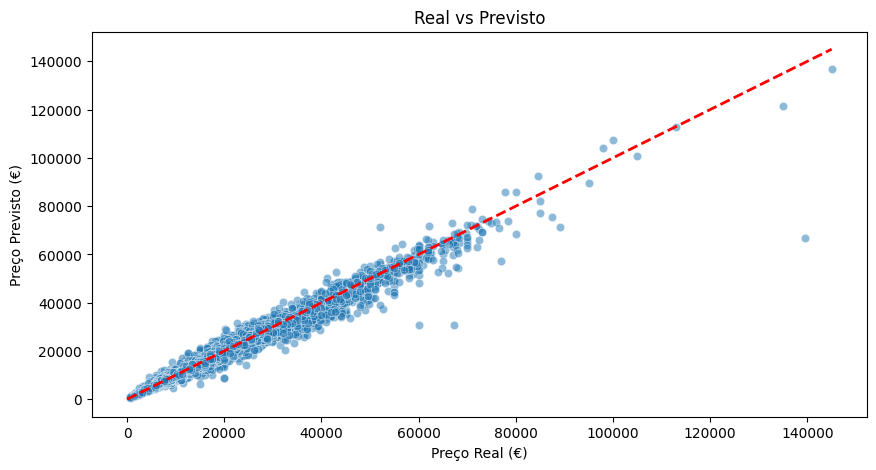

In [ ]:
# 1. Fazer Previsões (na Validação)
y_pred_log = best_gb.predict(X_val_scaled) 

# 2. Inverter o Log (CRUCIAL!)
y_pred_real = np.expm1(y_pred_log)
y_val_real = np.expm1(y_val)

# 3. Calcular Métricas
rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
mae = mean_absolute_error(y_val_real, y_pred_real)
r2 = r2_score(y_val_real, y_pred_real)
mape = mean_absolute_percentage_error(y_val_real, y_pred_real)

# 4. Imprimir Relatório
print("="*40)
print("     RELATÓRIO DE PERFORMANCE (GB)")
print("="*40)
print(f"R² Score: {r2:.4f}  (Quanto mais perto de 1.0, melhor)")
print(f"RMSE:     {rmse:.2f} €  (Penaliza erros grandes/outliers)")
print(f"MAE:      {mae:.2f} €  (Erro médio absoluto)")
print(f"MAPE:     {mape:.2%}   (Erro percentual médio)")
print("="*40)

# 5. Análise Visual (Resíduos)
# Se o modelo for bom, os pontos devem estar à volta da linha vermelha
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_val_real, y=y_pred_real, alpha=0.5)
plt.plot([0, y_val_real.max()], [0, y_val_real.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Preço Real (€)')
plt.ylabel('Preço Previsto (€)')
plt.title('Real vs Previsto')
plt.show()

In [ ]:
# 1. Prever no TREINO (O que o modelo já "estudou")
# Usamos X_train_scaled (ou X_combined com filtro de treino se usaste PredefinedSplit)
# Nota: Se usaste PredefinedSplit no X_combined, tens de filtrar o treino manualmente:
indices_treino = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_check = X_combined.iloc[indices_treino]
y_train_check = y_combined.iloc[indices_treino]

print("A calcular erro no Treino...")
y_pred_train_log = best_gb.predict(X_train_check) # Usa o teu modelo (best_gb, best_rf, etc.)
y_pred_train_real = np.expm1(y_pred_train_log)
y_train_real = np.expm1(y_train_check)

# 2. Prever na VALIDAÇÃO (O "Exame")
indices_val = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val_check = X_combined.iloc[indices_val]
y_val_check = y_combined.iloc[indices_val]

print("A calcular erro na Validação...")
y_pred_val_log = best_gb.predict(X_val_check)
y_pred_val_real = np.expm1(y_pred_val_log)
y_val_real = np.expm1(y_val_check)

# 3. Calcular RMSE para ambos
rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train_real))
rmse_val = np.sqrt(mean_squared_error(y_val_real, y_pred_val_real))

# 4. O Veredicto
print("\n" + "="*40)
print("     DIAGNÓSTICO DE OVERFITTING")
print("="*40)
print(f"RMSE Treino:     {rmse_train:.2f} €")
print(f"RMSE Validação:  {rmse_val:.2f} €")
print("-" * 40)

diferenca = rmse_val - rmse_train
perc_pior = (diferenca / rmse_train) * 100

print(f"Diferença:       {diferenca:.2f} €")
print(f"Piora na Validação: +{perc_pior:.1f}%")

if perc_pior < 10:
    print("✅ SITUAÇÃO: Excelente (Generalização Robusta)")
elif perc_pior < 20:
    print("⚠️ SITUAÇÃO: Normal (Ligeiro Overfitting, aceitável)")
else:
    print("🚨 SITUAÇÃO: OVERFITTING GRAVE (O modelo decorou o treino!)")

A calcular erro no Treino...
A calcular erro na Validação...

     DIAGNÓSTICO DE OVERFITTING
RMSE Treino:     1718.04 €
RMSE Validação:  1593.11 €
----------------------------------------
Diferença:       -124.93 €
Piora na Validação: +-7.3%
✅ SITUAÇÃO: Excelente (Generalização Robusta)


In [ ]:
# 1. Carregar
test_db = pd.read_csv("./test.csv")

# 2. Limpeza (Usando a tua função atualizada com typos/logs/nulos)
test_clean = clean_data(test_db) 

# 3. Encoding

# A. One-Hot
test_encoded = pd.get_dummies(test_clean, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# B. Target Encoding (Usar mapping do Treino)
if 'mapping' in locals():
    test_encoded["Brand_model_encoded"] = test_clean.apply(
        lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
    )
else:
    print("ERRO: Mapping não encontrado. Corre o bloco de treino primeiro.")

# 4. Preparação e Alinhamento
drop_cols = ["price", "carID", "model", "previousOwners"]
X_test_gb = test_encoded.drop(columns=drop_cols, errors='ignore')

# Alinhar colunas com o Treino (Fundamental)
if 'X_combined' in locals():
    cols_treino = X_combined.columns
    X_test_gb = X_test_gb.reindex(columns=cols_treino, fill_value=0)
else:
    print("ERRO: X_combined não encontrado.")

# 5. Scaling (GB beneficia de scaling, embora não seja estritamente obrigatório como NN/KNN)
# Vamos usar para manter consistência com o treino
X_test_gb_scaled = pd.DataFrame(scaler.transform(X_test_gb), columns=X_test_gb.columns, index=X_test_gb.index)

# 6. Previsão
print("A fazer previsões com Gradient Boosting...")
y_pred_gb_log = best_gb.predict(X_test_gb_scaled)
y_pred_gb_real = np.expm1(y_pred_gb_log)

# 7. Guardar
submission_gb = pd.DataFrame({
    "carID": test_db["carID"],
    "price": y_pred_gb_real
})

submission_gb.to_csv("submission_gb.csv", index=False)
print("Submissão 'submission_gb.csv' criada com sucesso!")

c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group_cat, target_col)
c:\Users\Rodrigo\Desktop\escola\4º Ano\ML\ProjetoML\functionsML.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby(all_helpers, dropna=False, group_keys=False).apply(fill_group

A fazer previsões com Gradient Boosting...
Submissão 'submission_gb.csv' criada com sucesso!
